In [1]:
import numpy as np
import copy
import json
import math
from glob import glob
import scipy.spatial.distance as sciDist
from tqdm import tqdm
import requests
import time
import itertools
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from itertools import islice
from PIL import Image
import re
from tqdm import tqdm


# Headless simulator version
index = 7 # local server index 
#API_ENDPOINT = 'http://localhost:400' + str(index) + '/simulation' # NOT THE LS VERSION
API_ENDPOINT = 'http://localhost:400' + str(4) + '/simulation' # NOT THE LS VERSION
HEADERS = {"Content-Type": "application/json"}
batchCount = 25 # Send this number of samples to MotionGen each time 
speedscale = 1
steps = 360
minsteps = int(steps*20/360)

# Search for "stephenson" or "watt" in the JSON file and collect their names and indices
json_path = "KV_468_062324.json"
with open(json_path, "r") as f:
    data = json.load(f)

matches = []
for idx, name in enumerate(data):
    lname = name.lower()
    if "steph" in lname or "watt" in lname:
        matches.append([name, idx])
print(matches)


# Things for 4 bar 
mechType = index
types = ['RRRR', 'RRRP', 'RRPR', 'PRPR']
for mechanism in matches:
    types.append(mechanism[0])
print(types)
# ['RRRR', 'RRRP', 'RRPR', 'PRPR', 'Watt2T1A1', 'Steph1T3', 'Watt1T1A1', 'Steph3T2A2', 'Watt1T3A2', 'Steph2T2A1', 'Steph3T1A2', 'Watt2T2A2', 'Watt1T2A1', 'Steph2T1A1', 'Steph3T2A1', 'Watt1T1A2', 'Watt2T1A2', 'Steph1T2', 'Steph1T1', 'Watt1T3A1', 'Watt1T2A2', 'Watt2T2A1', 'Steph3T1A1', 'Steph2T1A2', 'Steph2T2A2']

# Create a directory in outputs-6bar for each type in types
'''
for t in types:
    if t in ('RRRR', 'RRRP', 'RRPR', 'PRPR'):
        continue
    dir_path = os.path.abspath("./outputs-6bar/" + t)
    os.makedirs(dir_path, exist_ok=True)'''



typeIndex = [49, 64, 155, 175] # to avoid confusion from any other type
for mechanism in matches:
    typeIndex.append(mechanism[1])

print(typeIndex)
# [49, 64, 155, 175, 0, 2, 19, 26, 37, 39, 73, 82, 90, 110, 111, 125, 133, 135, 137, 139, 149, 163, 169, 176, 177]


couplerCurveIndex = [4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


#confirm that all c values are 1 at index 7 for 6 bars

bsi = "BSIdict_468_062324_3.json"
with open(bsi, "r") as b:
    data = json.load(b)

for key in types:
    if key in (data):
        c_value = (data)[key].get("c")
        if isinstance(c_value, list) and len(c_value) == 8:
            print(key, c_value)
            

savePointNumber = [5, 6, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] #len of c arrat acording to BSIdict
needAddtional = [False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False] # notice that when true, some of the points can change its position randomly 
initStates = np.load("./npy-inputs/" + 'Randpos-.npy')
errCtr = 0
batch = []
batchSaveStr = []
batchSaveNpyStr = []


# The transformation 
#np.save(saveDir + name + ' ' + types[index], param)
saveDir = os.path.abspath("./outputs-6bar/" + types[index] )
saveDirNpy = os.path.abspath("./outputs-6bar/" + types[index] + "-npy")
print(saveDir, saveDirNpy)

[['Watt2T1A1', 0], ['Steph1T3', 2], ['Watt1T1A1', 19], ['Steph3T2A2', 26], ['Watt1T3A2', 37], ['Steph2T2A1', 39], ['Steph3T1A2', 73], ['Watt2T2A2', 82], ['Watt1T2A1', 90], ['Steph2T1A1', 110], ['Steph3T2A1', 111], ['Watt1T1A2', 125], ['Watt2T1A2', 133], ['Steph1T2', 135], ['Steph1T1', 137], ['Watt1T3A1', 139], ['Watt1T2A2', 149], ['Watt2T2A1', 163], ['Steph3T1A1', 169], ['Steph2T1A2', 176], ['Steph2T2A2', 177]]
['RRRR', 'RRRP', 'RRPR', 'PRPR', 'Watt2T1A1', 'Steph1T3', 'Watt1T1A1', 'Steph3T2A2', 'Watt1T3A2', 'Steph2T2A1', 'Steph3T1A2', 'Watt2T2A2', 'Watt1T2A1', 'Steph2T1A1', 'Steph3T2A1', 'Watt1T1A2', 'Watt2T1A2', 'Steph1T2', 'Steph1T1', 'Watt1T3A1', 'Watt1T2A2', 'Watt2T2A1', 'Steph3T1A1', 'Steph2T1A2', 'Steph2T2A2']
[49, 64, 155, 175, 0, 2, 19, 26, 37, 39, 73, 82, 90, 110, 111, 125, 133, 135, 137, 139, 149, 163, 169, 176, 177]
Watt2T1A1 [0, 0, 0, 0, 0, 0, 0, 1]
Steph1T3 [0, 0, 0, 0, 0, 0, 0, 1]
Watt1T1A1 [0, 0, 0, 0, 0, 0, 0, 1]
Steph3T2A2 [0, 0, 0, 0, 0, 0, 0, 1]
Watt2T2A2 [0, 0, 0, 0

In [2]:
# good old ones 

def isValid(seq):
    if len(seq.shape) == 2:
        isVal = np.var(seq[:,0]) <= 5e-3 and np.var(seq[:,1]) <= 5e-3
    else:
        isVal = len(seq) == 0 or np.var(seq) <= 5e-3

    if isVal:
        return False
    else:
        return True


def get_pca_inclination(qx, qy, ax=None, label=''):
    """ Performs the PCA
        Return transformation matrix
    """
    cx = np.mean(qx)
    cy = np.mean(qy)
    covar_xx = np.sum((qx - cx)*(qx - cx))/len(qx)
    covar_xy = np.sum((qx - cx)*(qy - cy))/len(qx)
    covar_yx = np.sum((qy - cy)*(qx - cx))/len(qx)
    covar_yy = np.sum((qy - cy)*(qy - cy))/len(qx)
    covar = np.array([[covar_xx, covar_xy],[covar_yx, covar_yy]])
    eig_val, eig_vec= np.linalg.eig(covar)

    # Inclination of major principal axis w.r.t. x axis
    if eig_val[0] > eig_val[1]:
        phi= np.arctan2(eig_vec[1,0], eig_vec[0,0])
    else:
        phi= np.arctan2(eig_vec[1,1], eig_vec[0,1])

    return phi


def get_normalize_curve(jd, steps=None, rotations=1, normalize=True, transformParas=None):
    jd = np.array(jd)
    joint_data_n, x_mean, y_mean, denom, phi = [], None, None, None, None
    if isValid(jd):
        if steps:
            sample_indices = np.linspace(0, jd.shape[0]-1, steps, dtype=np.int32)
            jd = jd[sample_indices,:]
        if normalize:
            if not transformParas:
                x_mean = np.mean(jd[:,0], axis=0, keepdims=True)
                y_mean = np.mean(jd[:,1], axis=0, keepdims=True)
            else:
                x_mean, y_mean, denom, phi = transformParas
            jd[:,0] = jd[:,0] - x_mean
            jd[:,1] = jd[:,1] - y_mean

            if not transformParas:
                denom = np.sqrt(np.var(jd[:,0], axis=0, keepdims=True) + np.var(jd[:,1], axis=0, keepdims=True))
                denom = np.expand_dims(denom, axis=1)
            jd = jd / denom
            t = 0
        if not transformParas:
            phi = -get_pca_inclination(jd[:,0], jd[:,1])
        jd[:,0], jd[:, 1] = rotate_curve(jd, phi)
        for tt in range(rotations):
            joint_data_n.append(jd.copy())
            if rotations > 1:
                jd[:,0], jd[:,1] = rotate_curve(jd, t)
                t = 2*np.pi/rotations

    return joint_data_n, x_mean, y_mean, denom, phi


def rotate_curve(cur, theta):
    cpx = cur[:,0]*np.cos(theta) - cur[:,1]*np.sin(theta)
    cpy = cur[:,0]*np.sin(theta) + cur[:,1]*np.cos(theta)
    return cpx, cpy


def digitize_seq(nums, minlim, maxlim, bin_size=64):
    bins = np.linspace(minlim, maxlim, bin_size-1)
    nums_indices = np.digitize(nums, bins)
    return nums_indices


def get_normalize_joint_data_wrt_one_curve(joint_data, ref_ind = 4):
    ''' input s = [num_curves, num_points, 2]
    '''
    joint_data_n = []
    s = np.array(joint_data)
    if isValid(s[ref_ind]):
        x_mean = np.mean(s[ref_ind:ref_ind+1,:,0], axis=1, keepdims=True)
        y_mean = np.mean(s[ref_ind:ref_ind+1,:,1], axis=1, keepdims=True)
        s[:,:,0] = s[:,:,0] - x_mean
        s[:,:,1] = s[:,:,1] - y_mean
        denom = np.sqrt(np.var(s[ref_ind:ref_ind+1,:,0], axis=1, keepdims=True) + np.var(s[ref_ind:ref_ind+1,:,1], axis=1, keepdims=True))
        denom = np.expand_dims(denom, axis=2) #is this scale? 
        s = s / denom
        phi = -get_pca_inclination(s[ref_ind:ref_ind+1,:,0], s[ref_ind:ref_ind+1,:,1])
        for i in range(s.shape[0]):
            s[i,:,0], s[i,:,1] = rotate_curve(s[i], phi)
    else:
        return s, [None, None, None, None], False

    # s has a shape of (j_num, state, dim)
    return s, [x_mean[0][0], y_mean[0][0], denom[0][0][0], phi], True # tx, ty, scaling, rotation angle 


##############################################################################################
# There are some other necessary transformations. (x_mean, y_mean, phi, denom) are from get_normalize_curve. 
##############################################################################################
def get_image_from_point_cloud(points, xylim, im_size, inverted = True, label=None):
    mat = np.zeros((im_size, im_size, 1), dtype=np.uint8)
    x = digitize_seq(points[:,0], -xylim, xylim, im_size)
    if inverted:
        y = digitize_seq(points[:,1]*-1, -xylim, xylim, im_size)
        mat[y, x, 0] = 1
    else:
        y = digitize_seq(points[:,1], -xylim, xylim, im_size)
        mat[x, y, 0] = 1
    return mat


def process_mech_102723(jointData, ref_ind, im_size = 64, xylim = 3.5, inverted = True, swapAxes = True):
    paras = None

    # It is possible the jointData format is (angles, joint, (x, y)). 
    # You should put a True if this happens. (This is how files are saved).
    # I literally don't understand why I saved jointData with a shape of (angles, joint, (x, y)) 
    if swapAxes:
        jointData = np.swapaxes(jointData, 0, 1)

    # This converts all 
    jointData, paras, success = get_normalize_joint_data_wrt_one_curve(jointData, ref_ind= ref_ind)

    # jointData format from now on becomes np.array with a shape of (joint, curve_length, dimension)
    jointData = np.array(jointData)

    if success:
        # get binaryImage 
        jd = jointData[ref_ind]
        mat = get_image_from_point_cloud(jd, xylim=xylim, im_size=im_size, inverted=inverted)
        return mat, paras, success
    else: 
        return None, None, success


def calc_dist(coord):
    # Calculate differences using broadcasting
    diffs = coord[:, np.newaxis, :] - coord[np.newaxis, :, :]
    squared_dists = np.sum(diffs ** 2, axis=2)

    # Extract the upper triangle indices where i < j
    i, j = np.triu_indices(len(coord), k=1)
    dist_arr = np.sqrt(squared_dists[i, j])
    dist_arr = dist_arr/min(dist_arr)
    return np.round(dist_arr, 2)

In [3]:
############################################################################################## 
# An even better version of normalization method (it can be slower sometimes)
# Uses reflection correction (contributed by the paper Geometric Invariant Curve and Surface Normalization)  
# Thanks to Zhijie who noticed these two can be used together. 
##############################################################################################

def rotate_curve(curve, phi):
    infunction_scale = 100
    # curve is scaled 100 times for numerical accuracy 
    # incoming curve shape: (n,2)
    x = curve[:, 0] * infunction_scale
    y = curve[:, 1] * infunction_scale
    # Compute the rotated coordinates
    x_rotated = x * np.cos(phi) - y * np.sin(phi)
    y_rotated = x * np.sin(phi) + y * np.cos(phi)
    # Combine the rotated coordinates into a new curve
    rotated_curve = np.column_stack((x_rotated, y_rotated))
    return rotated_curve/infunction_scale


def center_data(X):
    """ Center the data by subtracting the mean of each column.
        Return the translated X and the translation matrix 
    """
    m = np.mean(X, axis=0) # (n, 2)
    return X - m, np.matrix([[1, 0, -m[0]], [0, 1, -m[1]], [0, 0, 1]]) # equal to XP this is a translation matrix tranposed  


def scale_data(X, scaling = 0): 
    """ Scale the data according to two different metrics 
        If scaling == 0 (default), scaling method is normalization (average distance 1)
        If otherwise, scaling method is standardization to a certain scale 
        Return the scaled X, and the scaling matrix. 
    """
    if scaling == 0:
        # use variance. 
        denom = np.sqrt(np.var(X[:,0]) + np.var(X[:,1]))
        scaled_curve = X /denom
        ScaleMat = np.matrix([[1/denom, 0, 0], [0, 1/denom, 0], [0, 0, 1]])
    else:
        # Compute the maximum distance from the origin 
        max_distance = np.max(np.linalg.norm(X, axis=1))
        scaled_curve = X * scaling / max_distance
        ScaleMat = np.matrix([[scaling/max_distance, 0, 0], [0, scaling/max_distance, 0], [0, 0, 1]])
    return scaled_curve, ScaleMat


def rotate_data(X, tol = 1e-4, randinit = False): 
    """ Performs the PCA and determines rotation angle phi 
        More precisely it is snapping the greatest principal axis to the X-axis. 
        Return the rotated X and the rotation matrix 
    """
    phiInit = 0
    if randinit:
        phiInit = np.random.rand() * math.pi * 2 

    rotationMatInit = np.matrix([
        [np.cos(phiInit), -np.sin(phiInit), 0], 
        [np.sin(phiInit), np.cos(phiInit), 0],
        [0, 0, 1] 
    ])

    X0 = rotate_curve(X, phiInit)
    cx = np.mean(X0[:,0])
    cy = np.mean(X0[:,1])
    covar_xx = np.sum((X0[:,0] - cx)*(X0[:,0] - cx))/X0.shape[0]
    covar_xy = np.sum((X0[:,0] - cx)*(X0[:,1] - cy))/X0.shape[0]
    covar_yx = np.sum((X0[:,1] - cy)*(X0[:,0] - cx))/X0.shape[0]
    covar_yy = np.sum((X0[:,1] - cy)*(X0[:,1] - cy))/X0.shape[0]
    covar = np.array([[covar_xx, covar_xy],[covar_yx, covar_yy]])

    if np.abs(np.linalg.det(covar)) < tol:
        phi = 0 # why rotate anyway? 
    else:
        eig_val, eig_vec= np.linalg.eig(covar) 
        # Inclination of major principal axis w.r.t. x axis
        # Enforcing the cross-product of the two eigenvectors to be greater than 0. 
        # Not necessary, but it looks clean to do so. 
        # Eigenvector matrix: [a, b], det = crossproduct of b x a
        if np.linalg.det(eig_vec) > 0:
            eig_vec[0,:] = -eig_vec[0,:] # enforcing a x b > 0 
        if eig_val[0] > eig_val[1]:
            phi= np.arctan2(eig_vec[1,0], eig_vec[0,0])
        else:
            phi= np.arctan2(eig_vec[1,1], eig_vec[0,1])
    rotated_curve = rotate_curve(X0, phi)
    rotationMat = np.matrix([
        [np.cos(phi), -np.sin(phi), 0], 
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1] 
    ])

    return rotated_curve, np.matmul(rotationMat, rotationMatInit)


def reflect_data(X):
    """ Computes the third order moment and determines the reflections 
        The data must be rotated before this step. 

    """
    # Reflection normalization 
    x_scaled = X[:, 0]
    y_scaled = X[:, 1]

    # see paper Geometric Invariant Curve and Surface Normalization
    # compute the 3rd-order moments 
    m12 = np.sum((x_scaled**1)*(y_scaled**2))
    m21 = np.sum((x_scaled**2)*(y_scaled**1))
    signm12 = np.sign(m12)
    signm21 = np.sign(m21)
    if np.abs(signm12) < 1e-5:
        signm12 = 1
    if np.abs(signm21) < 1e-5:
        signm21 = 1

    reflectionMat = np.array(
        [[signm12, 0],
         [0, signm21]]
    ) 

    if np.abs(m12) > np.abs(m21):
        reflectionMat = np.matmul(np.array([[0,1],[1,0]]), reflectionMat)

    reflected_Curve = np.matmul(reflectionMat, np.array(X).T).T
    reflectionMat = np.matrix(
        [[reflectionMat[0,0], reflectionMat[0,1], 0], 
         [reflectionMat[1,0], reflectionMat[1,1], 0], 
         [0, 0, 1]
        ]
    ) 

    return reflected_Curve, reflectionMat


# Digitization 
def digitize_seq(nums, minlim, maxlim, bin_size=64):
    bins = np.linspace(minlim, maxlim, bin_size-1)
    nums_indices = np.digitize(nums, bins)
    return nums_indices


def get_image_from_point_cloud(points, xylim, im_size, inverted = True, label=None):
    mat = np.zeros((im_size, im_size, 1), dtype=np.uint8)
    x = digitize_seq(points[:,0], -xylim, xylim, im_size)
    if inverted:
        y = digitize_seq(points[:,1]*-1, -xylim, xylim, im_size)
        mat[y, x, 0] = 1
    else:
        y = digitize_seq(points[:,1], -xylim, xylim, im_size)
        mat[x, y, 0] = 1
    return mat


# Returns normalized curve, Transformation matrix, and Success (if determinant is greater than tolerance for numerical stability)
def normalize_data_122223(X, scaling = 0, tol = 1e-8, maxiter = 2):
    X1, M1 = center_data(X) 
    X1, M2 = scale_data(X1, scaling = scaling)
    X1, M3 = rotate_data(X1)
    X1, M4 = reflect_data(X1)
    M = M4*M3*M2*M1 # This is the transformation matrix 

    detVal = np.abs(np.linalg.det(M))
    if detVal*scaling < tol:
        for i in range(maxiter):
            X1, M1 = center_data(X1)
            X1, M2 = scale_data(X1, scaling = scaling)
            X1, M3 = rotate_data(X1, randinit= True)
            X1, M4 = reflect_data(X1)
            if np.abs(np.linalg.det(M)) > tol or detVal*10 < np.abs(np.linalg.det(M)):
                break
    return X1, M4*M3*M2*M1, np.abs(np.linalg.det(M)) > tol


def matmul_jd(jd, mat):
    # input should be (..., ,2)
    # the operation: 
    jd = np.array(jd)
    oldshape = jd.shape
    njd= np.reshape(jd, (-1, 2))
    hc1= np.ones((njd.shape[0], 1))
    njd=np.matrix(np.concatenate([njd, hc1], axis = 1)).transpose()
    njd=np.array((mat*njd).transpose())[:,0:2].reshape(oldshape)
    return njd


# Processing 
# THIS IS THE MAIN FUNCTION YOU NEED (second version) 
# Input is the mechanism and coupler point index (ref_ind), Output is matImg, [<two transformation matrix instead of six parameters>], and Success. 
# NOTICE 1: the parameter has SIX parameters, not four (x, y translation, angle and scale). The addtional parameters are reflectionMat, seqReversed (refrlection matrix and whether or not the sequence is reverse in order)
# NOTICE 2: the transformation matrices are numpy arrays. You need to convert them to lists before converting them into .json format objects. 
# I suggest you save the a, b, c, d, e, f values in the matrix. 
# A transformation matrix is shaped as: 
# [[a, c, e]
#  [b, d, f]
#  [0, 0, 1]]
def process_mech_051524(jointData, ref_ind, im_size = 64, xylim = 3.5, inverted = True):
    # New JD shape is always (states, joints, dimensions)
    paras = None
    # get matrices according to curve. 
    nc, mat, success = normalize_data_122223(jointData[:,ref_ind,:], scaling = 3.5)
    NR_MG = mat # transform original position to normalized position # NR_MG * jointData = normalized joint data
    MG_NR = np.linalg.inv(NR_MG) 

    if success:
        # get binaryImage # rohit's choice on what to save 
        paras = NR_MG
        matImg = get_image_from_point_cloud(nc, xylim=xylim, im_size=im_size, inverted=inverted)
        return matImg, paras, success
    else: 
        return None, None, success

    
def calc_dist(coord):
    # Calculate differences using broadcasting
    diffs = coord[:, np.newaxis, :] - coord[np.newaxis, :, :]
    squared_dists = np.sum(diffs ** 2, axis=2)

    # Extract the upper triangle indices where i < j
    i, j = np.triu_indices(len(coord), k=1)
    dist_arr = np.sqrt(squared_dists[i, j])
    dist_arr = dist_arr/min(dist_arr)
    return np.round(dist_arr, 2)

In [4]:
def format_floats_to_string(float_list):
    formatted_strings = [f"{value:.3f}" for value in float_list]
    result_string = ' '.join(formatted_strings)
    return ' ' + result_string

# Example usage
float_values = [3920, -1.000e-03, 5.393e+00, 1.748e+00, -8.786e+00, 2.079e+00, 5.023e+00, -4.854e+00, 4.230e-01, 5.406e+00, -1.882e+00, -1.388e+00, 0.241, -0.285, 0.455, 0.899, 0.0, 1.0]

formatted_string = format_floats_to_string(float_values)
print(formatted_string)



 3920.000 -0.001 5.393 1.748 -8.786 2.079 5.023 -4.854 0.423 5.406 -1.882 -1.388 0.241 -0.285 0.455 0.899 0.000 1.000


 34%|███▍      | 3060/9000 [00:30<00:54, 108.48it/s]

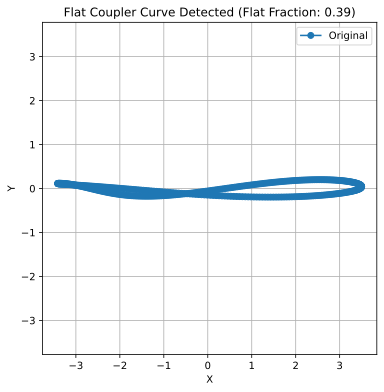

 35%|███▍      | 3106/9000 [00:30<00:53, 110.72it/s]

Saved flat coupler curve: /Users/Ray/simons2025/zhijie-old-simulator/Image-method-Synthesis-main/outputs-6bar/Steph3T2A2/-2.964 -6.691 -4.811 -8.871 2.538 -1.688 -2.468 -4.208 -3.668 2.988 0.717 -1.315 9.707 -0.8 8.772 -4.077 Steph3T2A2 -0.375 -0.815 2.96 0.815 -0.375 -8.498 0. 0. 1. .jpg


 38%|███▊      | 3417/9000 [00:33<00:57, 96.34it/s] 

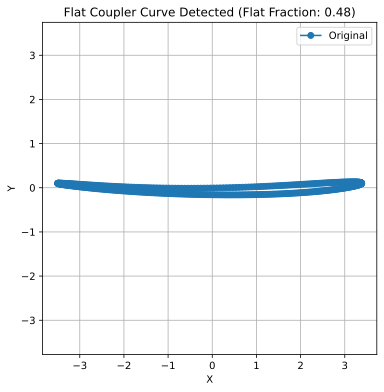

 39%|███▊      | 3466/9000 [00:34<01:05, 84.38it/s]

Saved flat coupler curve: /Users/Ray/simons2025/zhijie-old-simulator/Image-method-Synthesis-main/outputs-6bar/Steph3T2A2/-6.232 -7.596 -6.291 -5.273 6.738 2.857 3.821 -5.092 -4.935 4.139 -3.103 2.228 8.663 -5.143 -9.478 6.682 Steph3T2A2 -0.407 -0.909 -1.222 0.909 -0.407 11.44 0. 0. 1. .jpg


 51%|█████     | 4606/9000 [00:41<00:18, 235.88it/s]

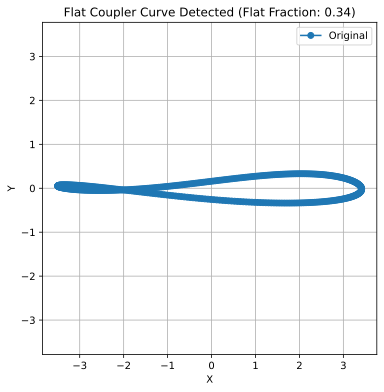

Saved flat coupler curve: /Users/Ray/simons2025/zhijie-old-simulator/Image-method-Synthesis-main/outputs-6bar/Steph3T2A2/0.239 -4.173 -0.598 -6.686 7.41 9.97 -2.247 9.007 -5.316 1.482 1.671 2.151 1.956 -9.789 3.026 8.993 Steph3T2A2 -0.65 0.475 -5.742 -0.475 -0.65 7.36 0. 0. 1. .jpg


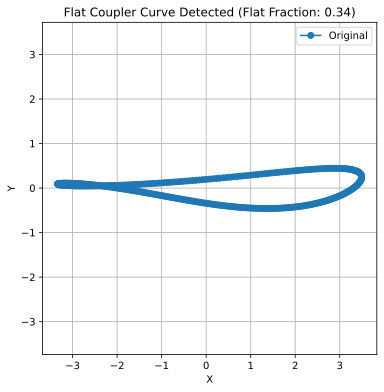

 52%|█████▏    | 4653/9000 [00:41<00:25, 167.64it/s]

Saved flat coupler curve: /Users/Ray/simons2025/zhijie-old-simulator/Image-method-Synthesis-main/outputs-6bar/Steph3T2A2/2.292 9.698 3.156 7.079 -9.152 8.248 -0.431 -8.641 -2.133 6.189 9.203 -6.148 9.637 -0.587 -2.047 2.181 Steph3T2A2  0.69 0.329 -1.501 -0.329 0.69 -2.15 0. 0. 1. .jpg


 64%|██████▍   | 5764/9000 [00:49<00:16, 191.53it/s]

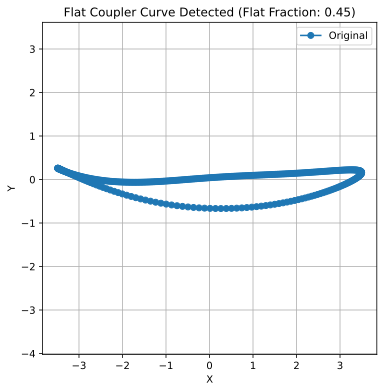

 65%|██████▍   | 5831/9000 [00:49<00:16, 195.08it/s]

Saved flat coupler curve: /Users/Ray/simons2025/zhijie-old-simulator/Image-method-Synthesis-main/outputs-6bar/Steph3T2A2/2.674 -1.576 0.409 -2.458 8.936 7.799 6.227 9.159 4.387 -3.215 1.007 -4.525 4.342 1.6 6.237 -5.673 Steph3T2A2  0.803 0.097 -4.97 -0.097 0.803 5.166 0. 0. 1. .jpg


 72%|███████▏  | 6457/9000 [00:53<00:13, 194.81it/s]

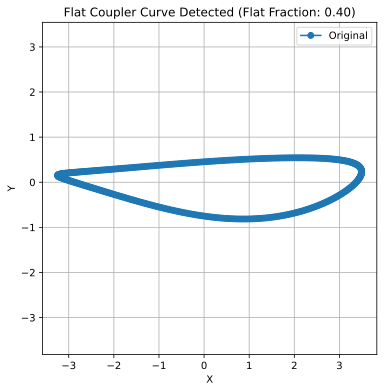

 72%|███████▏  | 6509/9000 [00:54<00:18, 132.09it/s]

Saved flat coupler curve: /Users/Ray/simons2025/zhijie-old-simulator/Image-method-Synthesis-main/outputs-6bar/Steph3T2A2/-6.076 -1.747 -8.994 -0.261 0.621 -1.509 1.728 2.819 3.688 -7.278 3.956 6.887 -8.684 5.765 6.493 4.848 Steph3T2A2  0.942 0.041 -8.066 -0.041 0.942 -4.64 0. 0. 1. .jpg


 95%|█████████▍| 8544/9000 [01:07<00:02, 181.80it/s]

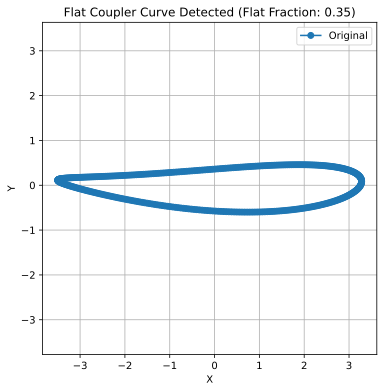

 96%|█████████▌| 8607/9000 [01:08<00:02, 170.79it/s]

Saved flat coupler curve: /Users/Ray/simons2025/zhijie-old-simulator/Image-method-Synthesis-main/outputs-6bar/Steph3T2A2/4.682 -0.482 3.472 1.125 7.993 4.294 -8.046 8.393 -8.257 -2.943 -8.937 2.128 0.237 -5.531 -1.388 -7.113 Steph3T2A2  1.29 1.039 9.911 1.039 -1.29 -8.333 0. 0. 1. .jpg


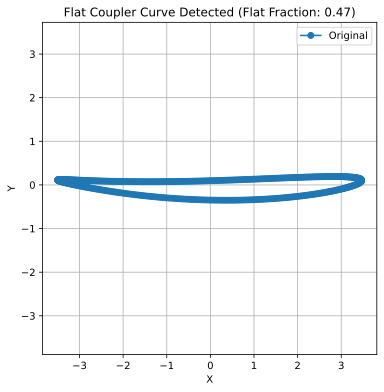

 96%|█████████▋| 8664/9000 [01:08<00:02, 125.96it/s]

Saved flat coupler curve: /Users/Ray/simons2025/zhijie-old-simulator/Image-method-Synthesis-main/outputs-6bar/Steph3T2A2/-6.267 9.456 -8.909 9.609 -3.74 -2.412 1.037 9.905 2.032 -6.315 8.814 4.911 5.283 -9.582 1.458 -3.627 Steph3T2A2  1.013 -0.431 -5.08 -0.431 -1.013 -2.968 0. 0. 1. .jpg


100%|██████████| 9000/9000 [01:11<00:00, 125.66it/s]


In [24]:
normFailCtr = 0

NUM_MECHS = 9000
#mechtype=6
#saveDir = os.path.abspath("./outputs-6bar/" + types[mechType] )
#

import numpy as np

# Optional imports
try:
    from scipy.signal import savgol_filter
    SCIPY_SAVGOL = True
except Exception:
    SCIPY_SAVGOL = False

# ---------- helpers ----------
def resample_uniform(points, M=1024):
    # points: (N,2)
    dif = np.diff(points, axis=0)
    seglen = np.sqrt((dif**2).sum(axis=1))
    s = np.concatenate(([0.0], np.cumsum(seglen)))
    total = s[-1]
    if total == 0:
        return np.repeat(points[:1], M, axis=0)
    s_uniform = np.linspace(0.0, total, M)
    x = np.interp(s_uniform, s, points[:,0])
    y = np.interp(s_uniform, s, points[:,1])
    return np.column_stack((x, y)), s_uniform

def normalize_path(pts):
    # center and scale by RMS radius (so curvature thresholds are roughly comparable)
    ptsc = pts - pts.mean(axis=0)
    scale = np.sqrt(np.mean(np.sum(ptsc**2, axis=1)))
    if scale <= 0:
        return ptsc, 1.0
    return ptsc / scale, scale

def lowpass_smooth(x, window=31, polyorder=3):
    # prefer Savitzky-Golay if available, else simple FFT low-pass
    if SCIPY_SAVGOL and window % 2 == 1 and window > polyorder:
        return savgol_filter(x, window_length=window, polyorder=polyorder, mode='wrap')
    # FFT low-pass fallback
    X = np.fft.fft(x)
    N = len(x)
    cutoff = max(3, N // 40)  # keep ~low freqs; adjust if needed
    mask = np.zeros(N, dtype=bool)
    mask[:cutoff] = True
    mask[-cutoff+1:] = True
    X_filtered = np.zeros_like(X)
    X_filtered[mask] = X[mask]
    x_smooth = np.fft.ifft(X_filtered).real
    return x_smooth

# ---------- core curvature-integral flat-finding ----------
def curvature_integral_flat_fraction(points, 
                                     M_resample=1024,
                                     smooth_window=51,
                                     kappa_threshold=0.95,
                                     min_flat_fraction=1/4,
                                     use_abs_curvature=True,
                                     verbose=False):
    """
    points: Nx2 array (one cycle of the coupler curve; should be closed or near-closed)
    returns: dict with metrics and boolean 'passes' for min_flat_fraction
    """
    # 1) resample uniformly along arc-length
    pts_resamp, s_uniform = resample_uniform(points, M=M_resample)
    # 2) normalize path for scale invariance
    pts_norm, scale = normalize_path(pts_resamp)  # scale used for normalization (returned)
    x = pts_norm[:,0].copy()
    y = pts_norm[:,1].copy()
    N = len(x)

    # 3) smooth coordinates to reduce noise prior to differentiation
    # choose window smaller than N and odd
    w = int(smooth_window)
    if w >= N: 
        w = N-1 if (N-1) % 2 == 1 else N-2
    if w < 5:
        w = 5 if 5 % 2 == 1 else 7
    x_s = lowpass_smooth(x, window=w)
    y_s = lowpass_smooth(y, window=w)

    # 4) compute derivatives wrt arc-length s (we have roughly uniform sampling in s)
    # use central differences
    ds = (s_uniform[-1] - s_uniform[0]) / (N - 1)
    dx_ds = np.gradient(x_s, ds)
    dy_ds = np.gradient(y_s, ds)
    d2x_ds2 = np.gradient(dx_ds, ds)
    d2y_ds2 = np.gradient(dy_ds, ds)

    # curvature formula (unsigned)
    denom = (dx_ds**2 + dy_ds**2)**1.5
    # prevent division by zero
    denom_safe = denom.copy()
    denom_safe[denom_safe == 0] = 1e-12
    kappa = np.abs(dx_ds * d2y_ds2 - dy_ds * d2x_ds2) / denom_safe
    if not use_abs_curvature:
        # sign-preserving curvature: sign = sign(dx*ddy - dy*ddx)
        sign = np.sign(dx_ds * d2y_ds2 - dy_ds * d2x_ds2)
        kappa = sign * kappa

    # 5) cumulative curvature integral K(s)
    # numeric integral via cumulative trapezoid (approx)
    K = np.cumsum(kappa) * ds  # simple Riemann sum approximation

    # 6) re-sample kappa as function of K at uniform K steps
    K_total = K[-1]
    if K_total <= 0:
        # degenerate: curvature zero everywhere (straight line)
        # treat entire curve as flat
        return {
            'passes': True,
            'flat_fraction': 1.0,
            'kappa': kappa,
            'K': K,
            'kappa_threshold': kappa_threshold,
            'notes': 'degenerate_zero_curvature'
        }

    M_K = N  # number of samples along K-axis (can be a separate param)
    K_uniform = np.linspace(0.0, K_total, M_K)
    # invert K(s): use np.interp to map uniform K to s indices then sample kappa
    s_at_K = np.interp(K_uniform, K, s_uniform)
    # sample kappa at those s positions using interpolation of original kappa(s_uniform)
    kappa_at_K = np.interp(s_at_K, s_uniform, kappa)

    # 7) flat mask: contiguous regions where kappa < kappa_threshold
    flat_mask = (kappa_at_K < kappa_threshold)
    # find longest contiguous run of True in flat_mask (circular wrap considered since closed path)
    # handle wrap-around by doubling
    flat_doubled = np.concatenate([flat_mask, flat_mask])
    # find runs
    max_run = 0
    cur = 0
    for val in flat_doubled:
        if val:
            cur += 1
            if cur > max_run:
                max_run = cur
        else:
            cur = 0
    # clip max_run to at most M_K (since doubled)
    if max_run > M_K:
        max_run = M_K
    flat_fraction = max_run / float(M_K)

    passes = flat_fraction >= min_flat_fraction

    result = {
        'passes': bool(passes),
        'flat_fraction': float(flat_fraction),
        'max_run_samples': int(max_run),
        'M_K': int(M_K),
        'kappa_threshold': float(kappa_threshold),
        'kappa_mean': float(np.mean(kappa_at_K)),
        'kappa_median': float(np.median(kappa_at_K)),
        'kappa_array': kappa_at_K,
        'K_array': K_uniform,
        'scale': float(scale),
        'notes': ''
    }
    if verbose:
        print("scale:", scale, "K_total:", K_total, "flat_fraction:", flat_fraction, "passes:", passes)
    return result


def is_closed(pts):
    # Check if path is open or closed
    start_pt = pts[0]
    end_pt = pts[-1]
    path_dist = np.linalg.norm(end_pt - start_pt)
    is_closed = path_dist < 0.1
    return is_closed

def flat_fraction_simple(points, eps=0.08, min_fraction=1/3):
    pts_resamp, _ = resample_uniform(points, M=1024)
    pts_norm, _ = normalize_path(pts_resamp)
    x, y = pts_norm[:,0], pts_norm[:,1]

    # derivatives
    dx, dy = np.gradient(x), np.gradient(y)
    d2x, d2y = np.gradient(dx), np.gradient(dy)
    denom = (dx**2 + dy**2)**1.5
    denom[denom == 0] = 1e-12
    kappa = np.abs(dx*d2y - dy*d2x) / denom

    flat_mask = (kappa < eps)
    flat_fraction = flat_mask.sum() / len(flat_mask)

    return {"passes": bool(flat_fraction >= min_fraction), 
            "flat_fraction": float(flat_fraction)}





for initState in tqdm(initStates[mechType*NUM_MECHS: (mechType+1)*NUM_MECHS, :8*2]):
    coord = np.round(initState, 3).reshape((8,2))
    dist = calc_dist(coord)

    if max(dist) > 10:
        continue

    param = coord.tolist()

    name = str(param).replace("[", "").replace("]", "").replace(",", "") 

    exampleData = {
        'type': types[mechType], 
        'params': param,
        'speedScale':speedscale, # 1 
        'steps':steps, # 360 
        'relativeTolerance':0.1 
    }


    batch.append(exampleData) #... You should use a function to decide save str. 
    batchSaveStr.append(saveDir + '/' + name )       # old method of doing things 
    batchSaveNpyStr.append(saveDirNpy + '/' + name ) # old method of doing things 

    if len(batch) >= batchCount:
        try:
            temp = requests.post(url = API_ENDPOINT, headers=HEADERS, data = json.dumps(batch)).json()
            time.sleep(0.02)
        except ValueError as v:
            for i in range(3):
                time.sleep(2)
                try:
                    temp = requests.post(url = API_ENDPOINT, headers=HEADERS, data = json.dumps(batch)).json()
                    break
                except ValueError as v2:
                    errCtr += 1
        for i in range(len(temp)):
            P = np.array(temp[i]['poses'])
            try:
                if len(P.shape) >= 1:
                    if P.shape[0] >= minsteps:
                        # do normalization, also get the transformation parameters. 
                        # also the paras are saved instead of MP (M: tranformation matrix, P: points in the matrix)
                        # This is just to avoid decimal difference problem 
                        imageMat, transParamSet, success = process_mech_051524(P, couplerCurveIndex[mechType])
                        if success:

                            # change Tstr if needed 
                            # normalized coords
                            normalized_coords = normalize_data_122223(P[:,couplerCurveIndex[mechType],:], scaling=3.5)[0]
                            #print(normalized_coords)
                            import matplotlib.pyplot as plt

                            '''plt.figure(figsize=(6, 6))
                            plt.plot(normalized_coords[:, 0], normalized_coords[:, 1], marker='o')
                            plt.title('Normalized Coupler Curve')
                            plt.xlabel('X')
                            plt.ylabel('Y')
                            plt.axis('equal')
                            plt.grid(True)
                            plt.show()'''

                            # Compute Fourier descriptors
                            fd = np.fft.fft(normalized_coords[:, 0] + 1j * normalized_coords[:, 1])
                            #print(fd)

                            # Inverse FFT to reconstruct curve
                            reconstructed = np.fft.ifft(fd)
                            reconstructed_coords = np.column_stack((reconstructed.real, reconstructed.imag))

                            curvature_integral_output = curvature_integral_flat_fraction(normalized_coords)

                            has_flat_portion = flat_fraction_simple(normalized_coords)['passes']
                            flat_fraction = flat_fraction_simple(normalized_coords)['flat_fraction']

                            if has_flat_portion and is_closed(normalized_coords):
                                plt.figure(figsize=(6, 6))
                                plt.plot(normalized_coords[:, 0], normalized_coords[:, 1], label='Original', marker='o')
                                #plt.title(f'Flat Coupler Curve Detected (Flat Fraction: {curvature_integral_output["flat_fraction"]:.2f})')
                                plt.title(f'Flat Coupler Curve Detected (Flat Fraction: {flat_fraction:.2f})')
                                plt.xlabel('X')
                                plt.ylabel('Y')
                                plt.axis('equal')
                                plt.grid(True)
                                plt.legend()
                                plt.show()
                                #print("curvature integral out:", curvature_integral_output)

                            '''# Plot original and reconstructed curves
                            plt.figure(figsize=(6, 6))
                            plt.plot(normalized_coords[:, 0], normalized_coords[:, 1], label='Original', marker='o')
                            plt.plot(reconstructed_coords[:, 0], reconstructed_coords[:, 1], label='Reconstructed', linestyle='--', marker='x')

                             # Use only the first N low-frequency Fourier coefficients for smoothing
                            N = 10  # You can adjust N for more/less smoothing

                            fd_low = np.zeros_like(fd)
                            fd_low[:N] = fd[:N]
                            fd_low[-N+1:] = fd[-N+1:]

                            smoothed = np.fft.ifft(fd_low)
                            smoothed_coords = np.column_stack((smoothed.real, smoothed.imag))

                            plt.plot(smoothed_coords[:, 0], smoothed_coords[:, 1], label=f'Smoothed (N={N})', color='red', linewidth=2)



                            plt.title('Original vs Reconstructed Curve (FFT)')
                            plt.xlabel('X')
                            plt.ylabel('Y')
                            plt.axis('equal')
                            plt.grid(True)
                            plt.legend()
                            plt.show()

                            print(compute_fd_features(normalized_coords))'''


                            # change Tstr if needed 
                            Tstr = np.array2string(np.round(transParamSet, 3), precision=3, suppress_small=True).replace("[", "").replace("]", "") # Wei asked for this part
                            Tstr = re.sub('\s+', ' ', Tstr) # to replace multiple sequential spaces together
                            binary_data = np.uint8(imageMat[:,:,0]) * 255
                            img = Image.fromarray(binary_data)
                            if needAddtional[mechType]: # need additional description (replace old method)
                                pinit = (np.array(temp[i]['posInit'])[:savePointNumber[mechType], :].flatten().tolist())
                                name = format_floats_to_string(pinit)
                                img.save(saveDir + '/' + name + ' ' + types[mechType] + ' '  + Tstr + '.jpg')
                            else:                       # traditional if no added 
                                img.save(batchSaveStr[i] + ' ' + types[mechType] + ' ' + Tstr + '.jpg')

                            if has_flat_portion and is_closed(normalized_coords):
                                print("Saved flat coupler curve:", batchSaveStr[i] + ' ' + types[mechType] + ' '  + Tstr + '.jpg')
                            #plt.imshow(imageMat)
                            #plt.savefig(batchSaveStr[i] + Tstr + '.jpg')
                            #plt.clf()
                        else: 
                            normFailCtr += 1
                        pass                        
            except ValueError as v:
                print(v)
            except FileNotFoundError as f:
                print(f)
        batch = []
        batchSaveStr = []
        batchSaveNpyStr = []

if len(batch) >= batchCount:
    #print(batch[0], '\n', batch[1])
    #print(batchSaveStr[0], '\n', batchSaveStr[1])
    try:
        temp = requests.post(url = API_ENDPOINT, headers=HEADERS, data = json.dumps(batch)).json()
        time.sleep(0.02)
    except ValueError as v:
        for i in range(3):
            time.sleep(2)
            try:
                temp = requests.post(url = API_ENDPOINT, headers=HEADERS, data = json.dumps(batch)).json()
                break
            except ValueError as v2:
                    errCtr += 1
    print(errCtr)
    for i in range(len(temp)):
        P = np.array(temp[i]['poses']) 
        try:
            if len(P.shape) >= 1:
                if P.shape[0] >= minsteps:
                    # do normalization, also get the transformation parameters. 
                    # also the paras are saved instead of MP (M: tranformation matrix, P: points in the matrix)
                    # This is just to avoid decimal difference problem 
                    imageMat, transParamSet, success = process_mech_051524(P, couplerCurveIndex[mechType])
                    if success:
                        Tstr = np.array2string(np.round(transParamSet, 3), precision=3, suppress_small=True).replace("[", "").replace("]", "") # Wei asked for this part
                        Tstr = re.sub('\s+', ' ', Tstr) # to replace multiple sequential spaces together
                        binary_data = np.uint8(imageMat[:,:,0]) * 255
                        img = Image.fromarray(binary_data)
                        if needAddtional[mechType]: # need additional description (replace old method)
                            pinit = (np.array(temp[i]['posInit'])[:savePointNumber[mechType], :].flatten().tolist())
                            name = format_floats_to_string(pinit)
                            img.save(saveDir + '/' + name + ' ' + types[mechType] + ' '  + Tstr + '.jpg')
                        else:                       # traditional if no added 
                            img.save(batchSaveStr[i] + ' ' + types[mechType] + ' '  + Tstr + '.jpg') 

                        if has_flat_portion and is_closed(normalized_coords):
                                print("Saved flat coupler curve:", batchSaveStr[i] + ' ' + types[mechType] + ' '  + Tstr + '.jpg')
                        #plt.imshow(imageMat)
                        #plt.savefig(batchSaveStr[i] + Tstr + '.jpg')
                        #plt.clf()
                    else:
                        normFailCtr += 1
                        pass       
        except ValueError as v:
            print(v)
        except FileNotFoundError as f:
            print(f)
    batch = []
    batchSaveStr = []
    batchSaveNpyStr = []

In [ ]:
print(normFailCtr) # basically not too many steps is the reason. 
print(P.shape)